In [3]:
import experiments_func as exp
import matplotlib.pyplot as plt

In [4]:
experiment = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

random_nodes_random_result = []
random_nodes_greedy_result = []
top_nodes_random_result = []
top_nodes_greedy_result = []

for i, blocks in enumerate(experiment):
    print(f'{i+1}回目, ブロック数: {blocks}')
    random_nodes_random_cost, random_nodes_greedy_cost, top_nodes_random_cost, top_nodes_greedy_cost = exp.experiment(blocks)
    random_nodes_random_result.append(random_nodes_random_cost)
    random_nodes_greedy_result.append(random_nodes_greedy_cost)
    top_nodes_random_result.append(top_nodes_random_cost)
    top_nodes_greedy_result.append(top_nodes_greedy_cost)

1回目, ブロック数: 500
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 16496
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 0
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 16525
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 0

2回目, ブロック数: 1000
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 31419
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 0
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 35994
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 0

3回目, ブロック数: 1500
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 49385
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 24
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 49824
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 8

4回目, ブロック数: 2000
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 58976
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 72
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 63105
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 8

5回目, ブロック数: 2500
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 67042
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 72
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 79829
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 84

6回目, ブロック数: 3000
ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: 71144
ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: 240
上位のノードを選択しランダムに割り当てた場合の総通信コスト: 79476
上位のノードを選択し提案手法で割り当てた場合の総通信コスト: 64

7回目, ブロック数: 3500
ランダムに

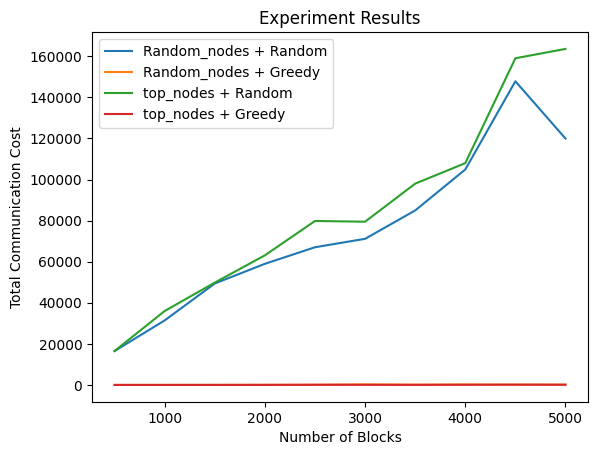

In [5]:
# グラフの設定
plt.plot(experiment, random_nodes_random_result, label='Random_nodes + Random')
plt.plot(experiment, random_nodes_greedy_result, label='Random_nodes + Greedy')
plt.plot(experiment, top_nodes_random_result, label='top_nodes + Random')
plt.plot(experiment, top_nodes_greedy_result, label='top_nodes + Greedy')

plt.xlabel('Number of Blocks')
plt.ylabel('Total Communication Cost')
plt.title('Experiment Results')
plt.legend()
# グラフの保存
plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/graph1.png')
# グラフの表示
plt.show()


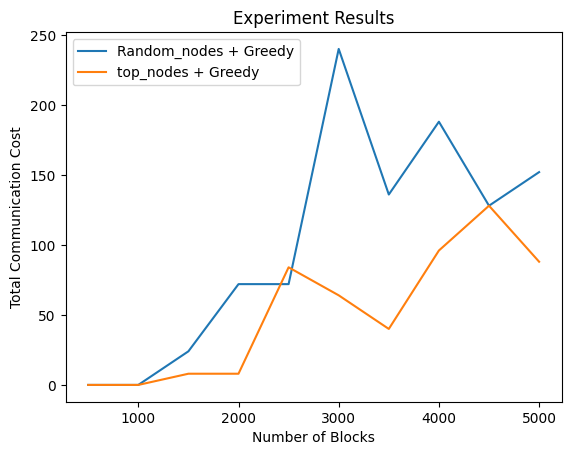

In [6]:
plt.plot(experiment, random_nodes_greedy_result, label='Random_nodes + Greedy')
plt.plot(experiment, top_nodes_greedy_result, label='top_nodes + Greedy')

plt.xlabel('Number of Blocks')
plt.ylabel('Total Communication Cost')
plt.title('Experiment Results')
plt.legend()

# グラフの保存
plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/graph2.png')
# グラフの表示
plt.show()
